# Henry Gu - Advanced Machine Learning Assignment 3 - Recurrent Neural Networks

Achieved a Score Set R2 of 0.9113613745

# Load Packages and Data

In [2]:
# # Run this cell to configure Tensorflow to use your GPU
# import tensorflow as tf
    
# # tf.config.experimental.set_visible_devices([], 'GPU')
# # tf.debugging.set_log_device_placement(True)
# for gpu in tf.config.experimental.list_physical_devices('GPU'):
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
%%capture
# prefix redacted for privacy

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

# Pre-process Data

In [5]:
train_X.shape, validate_X.shape, test_X.shape

((826464, 4), (54912, 4), (52248, 4))

In [6]:
all_X = pd.concat([train_X, validate_X, test_X])
temp_X = all_X.reset_index()

In [7]:
val_cutoff_X = "2016-04-22"
test_cutoff_X = "2017-01-01"

In [8]:
print('Number of validation observations:', temp_X[temp_X['time'] >= val_cutoff_X].shape[0] - temp_X[temp_X['time'] >= test_cutoff_X].shape[0])
print('Number of test observations', temp_X[temp_X['time'] >= test_cutoff_X].shape[0])
print('Validation percentage:', temp_X[temp_X['time'] >= val_cutoff_X].shape[0] / temp_X.shape[0] - temp_X[temp_X['time'] >= test_cutoff_X].shape[0] / temp_X.shape[0])
print('Test percentage:', temp_X[temp_X['time'] >= test_cutoff_X].shape[0] / temp_X.shape[0])

Number of validation observations: 107736
Number of test observations 107160
Validation percentage: 0.11539549111848023
Test percentage: 0.1147785403974191


In [9]:
test_X = all_X.query('time >= "' + test_cutoff_X + '"')
validate_X = all_X.query('time >= "' + val_cutoff_X + '" & time < "' + test_cutoff_X + '"')
train_X = all_X.query('time < "' + val_cutoff_X + '"')
train_X.shape, validate_X.shape, test_X.shape

((718728, 4), (107736, 4), (107160, 4))

In [10]:
train_y.shape, validate_y.shape, test_y.shape

((826464, 4), (54912, 4), (52248, 4))

In [11]:
val_cutoff_y = "2016-04-23"
test_cutoff_y = "2017-01-02"

In [12]:
all_y = pd.concat([train_y, validate_y, test_y])
test_y = all_y.query('time >= "' + test_cutoff_y + '"')
validate_y = all_y.query('time >= "' + val_cutoff_y + '" & time < "' + test_cutoff_y + '"')
train_y = all_y.query('time < "' + val_cutoff_y + '"')
train_y.shape, validate_y.shape, test_y.shape

((718728, 4), (107736, 4), (107160, 4))

In [13]:
# Check to make sure whole samples are in each section
import numpy as np
print(np.unique(np.asarray(pd.DataFrame(train_X.groupby('sample').size()))))
print(np.unique(np.asarray(pd.DataFrame(train_y.groupby('sample').size()))))
print(np.unique(np.asarray(pd.DataFrame(validate_X.groupby('sample').size()))))
print(np.unique(np.asarray(pd.DataFrame(validate_y.groupby('sample').size()))))
print(np.unique(np.asarray(pd.DataFrame(test_X.groupby('sample').size()))))
print(np.unique(np.asarray(pd.DataFrame(test_y.groupby('sample').size()))))

[24]
[24]
[24]
[24]
[24]
[24]


In [14]:
test_X.head(5)

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/2102/0 2017-02-28 20:00:00       285.55      43.0    1010.0   
                   2017-02-28 21:00:00       284.76      37.0    1010.0   
                   2017-02-28 22:00:00       284.15      32.0    1011.0   
                   2017-02-28 23:00:00       284.75      29.0    1011.0   
                   2017-03-01 00:00:00       284.62      25.0    1012.0   

                                        wind_speed  
sample             time                             
Albuquerque/2102/0 2017-02-28 20:00:00        18.0  
                   2017-02-28 21:00:00        18.0  
                   2017-02-28 22:00:00        13.0  
                   2017-02-28 23:00:00        13.0  
                   2017-03-01 00:00:00        12.0

In [15]:
test_y.head(5)

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/2102/0 2017-03-01 20:00:00       279.63      14.0    1026.0   
                   2017-03-01 21:00:00       280.64      12.0    1025.0   
                   2017-03-01 22:00:00       281.64      12.0    1025.0   
                   2017-03-01 23:00:00       281.63      12.0    1025.0   
                   2017-03-02 00:00:00       281.37      17.0    1025.0   

                                        wind_speed  
sample             time                             
Albuquerque/2102/0 2017-03-01 20:00:00         4.0  
                   2017-03-01 21:00:00         5.0  
                   2017-03-01 22:00:00         1.0  
                   2017-03-01 23:00:00         1.0  
                   2017-03-02 00:00:00         6.0

In [16]:
train_X.index = train_X.index.remove_unused_levels()
validate_X.index = validate_X.index.remove_unused_levels()
test_X.index = test_X.index.remove_unused_levels()
train_y.index = train_y.index.remove_unused_levels()
validate_y.index = validate_y.index.remove_unused_levels()
test_y.index = test_y.index.remove_unused_levels()

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [18]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(718728, 4)","(29947, 24, 4)"
train_y,"(718728, 4)","(29947, 24)"


In [19]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = scaled_X['score'].reshape(-1, condition_window, features_length).astype('float32')

In [20]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
        test_X_nd.shape,
        test_y_nd.shape,
        score_X_nd.shape
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
        expected_X_shape(test_X.shape), 
        expected_y_shape(test_y.shape),
        expected_X_shape(score_X.shape)
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y', 'test_X', 'test_y', 'score_X']
)

,actual shape,expected shape
train_X,"(29947, 24, 4)","(29947, 24, 4)"
train_y,"(29947, 24)","(29947, 24)"
validate_X,"(4489, 24, 4)","(4489, 24, 4)"
validate_y,"(4489, 24)","(4489, 24)"
test_X,"(4465, 24, 4)","(4465, 24, 4)"
test_y,"(4465, 24)","(4465, 24)"
score_X,"(2399, 24, 4)","(2399, 24, 4)"


## Model Initialization, Design and Training

In [21]:
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.layers import Dense, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python import GlorotUniform, Orthogonal

layers = [
        GRU(
            input_shape=(condition_window, features_length),
            units=150,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=39),
            recurrent_initializer=GlorotUniform(seed=56),
            kernel_regularizer = tf.keras.regularizers.l1()
        ),
        BatchNormalization(),    
        GRU(
            units=25,
            return_sequences=False,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=10),
            recurrent_initializer=GlorotUniform(seed=18),
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=88),
            activation='linear'
        )
]

model = Sequential(layers)

2021-10-19 01:02:47.955708: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-19 01:02:48.102994: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-19 01:02:48.103048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-33-224): /proc/driver/nvidia/version does not exist
2021-10-19 01:02:48.104138: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-10-19 01:02:48.111098: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2499995000 Hz
2021-10-19 01:02:48.111369: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ebf730f700 initialized for platform Host (this does not guarantee that XLA will 

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 150)           70200     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 150)           600       
_________________________________________________________________
gru_1 (GRU)                  (None, 25)                13275     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense (Dense)                (None, 24)                624       
Total params: 84,799
Trainable params: 84,449
Non-trainable params: 350
_________________________________________________________________


In [23]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.01),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

In [24]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

checkpoint_filepath = 'tmp/checkpoint'

def scheduler(epoch, lr):
    if epoch == 1:
        lr = 0.001
    if epoch == 10:
        lr = 0.0001
    return lr

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=100,
    batch_size=150,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.2,
            factor=0.2,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        LearningRateScheduler(scheduler),
        EarlyStopping(
            monitor='val_loss',
            patience=30
        ),
        ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            mode="min",
            verbose=1
        )
    ]
)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 53698.9375 - mean_absolute_error: 224.3235 - r2_score: -401.6218 - mean_error: -224.1092
Epoch 00001: val_loss improved from inf to 10980.11035, saving model to tmp/checkpoint
200/200 [==============================] - 17s 84ms/step - loss: 53698.9375 - mean_absolute_error: 224.3235 - r2_score: -401.6218 - mean_error: -224.1092 - val_loss: 10980.1104 - val_mean_absolute_error: 104.4958 - val_r2_score: -271.0372 - val_mean_error: -104.4823 - lr: 0.0100
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 7820.5029 - mean_absolute_error: 87.9889 - r2_score: -57.6140 - mean_error: -87.9648
Epoch 00002: val_loss improved from 10980.11035 to 5756.67383, saving model to tmp/checkpoint
200/200 [==============================] - 16s 82ms/step - loss: 7820.5029 - mean_absolute_error: 87.9889 - r2_score: -57.6140 - mean_error: -87.9648 - val_loss: 5756.6738 - val_mean_absolute_error: 75.7020 - val_r2_score: 

In [25]:
model.load_weights(checkpoint_filepath)

## Model Evaluation

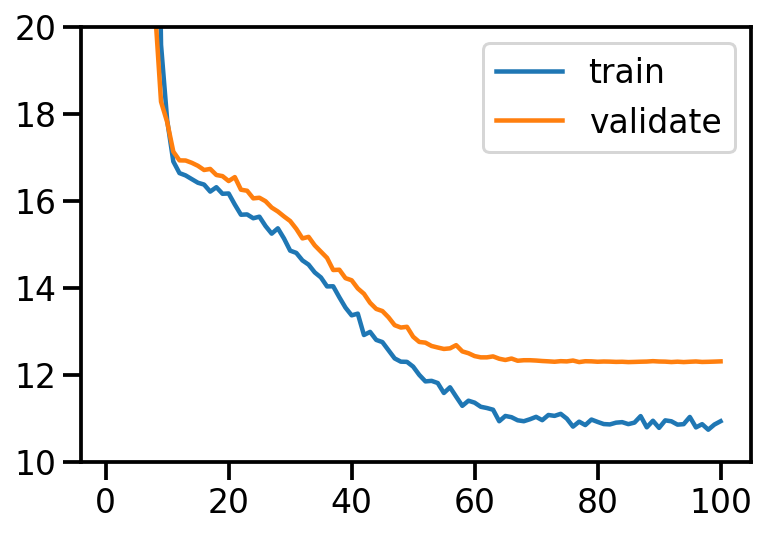

In [26]:
epochs = range(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

plt.legend(['train', 'validate'])
plt.ylim(top=20, bottom=10)
plt.show()

In [27]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(5)

rnn_metrics

train                            validate                             \
         MSE      MAE       R2       ME      MSE      MAE       R2       ME   
rnn  9.78582  2.29923  0.92968 -0.04135  12.2883  2.53292  0.91571 -0.04645   

         test                             
          MSE      MAE       R2       ME  
rnn  16.52167  3.05557  0.88014 -0.15573

In [28]:
from utils import Segment, SegmentDataset, baseline_metrics

segment_names = ['train', 'validate', 'test']
segment_data = [(train_X, train_y), (validate_X, validate_y), (test_X, test_y)]
out_list = []
for segment, data in zip(segment_names, segment_data):
    tmp_segment = Segment(segment)
    for frame_name, frame_data in zip(['x', 'y'], data):
        tmp_segment.frames[frame_name] = frame_data
    out_list.append(tmp_segment)

panel_dataset = SegmentDataset()
for name, data in zip(segment_names, out_list):
    panel_dataset[name] = data
baseline_metrics = baseline_metrics(panel_dataset)

In [29]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(3)

test         train       validate       
                MSE    R2     MSE    R2      MSE     R2
mean         33.270  0.75  26.870  0.80   26.530  0.810
constant     30.480  0.78  22.060  0.84   20.160  0.860
regression  263.220 -0.94  30.590  0.77   29.880  0.790
rnn          16.522  0.88   9.786  0.93   12.288  0.916

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() inst

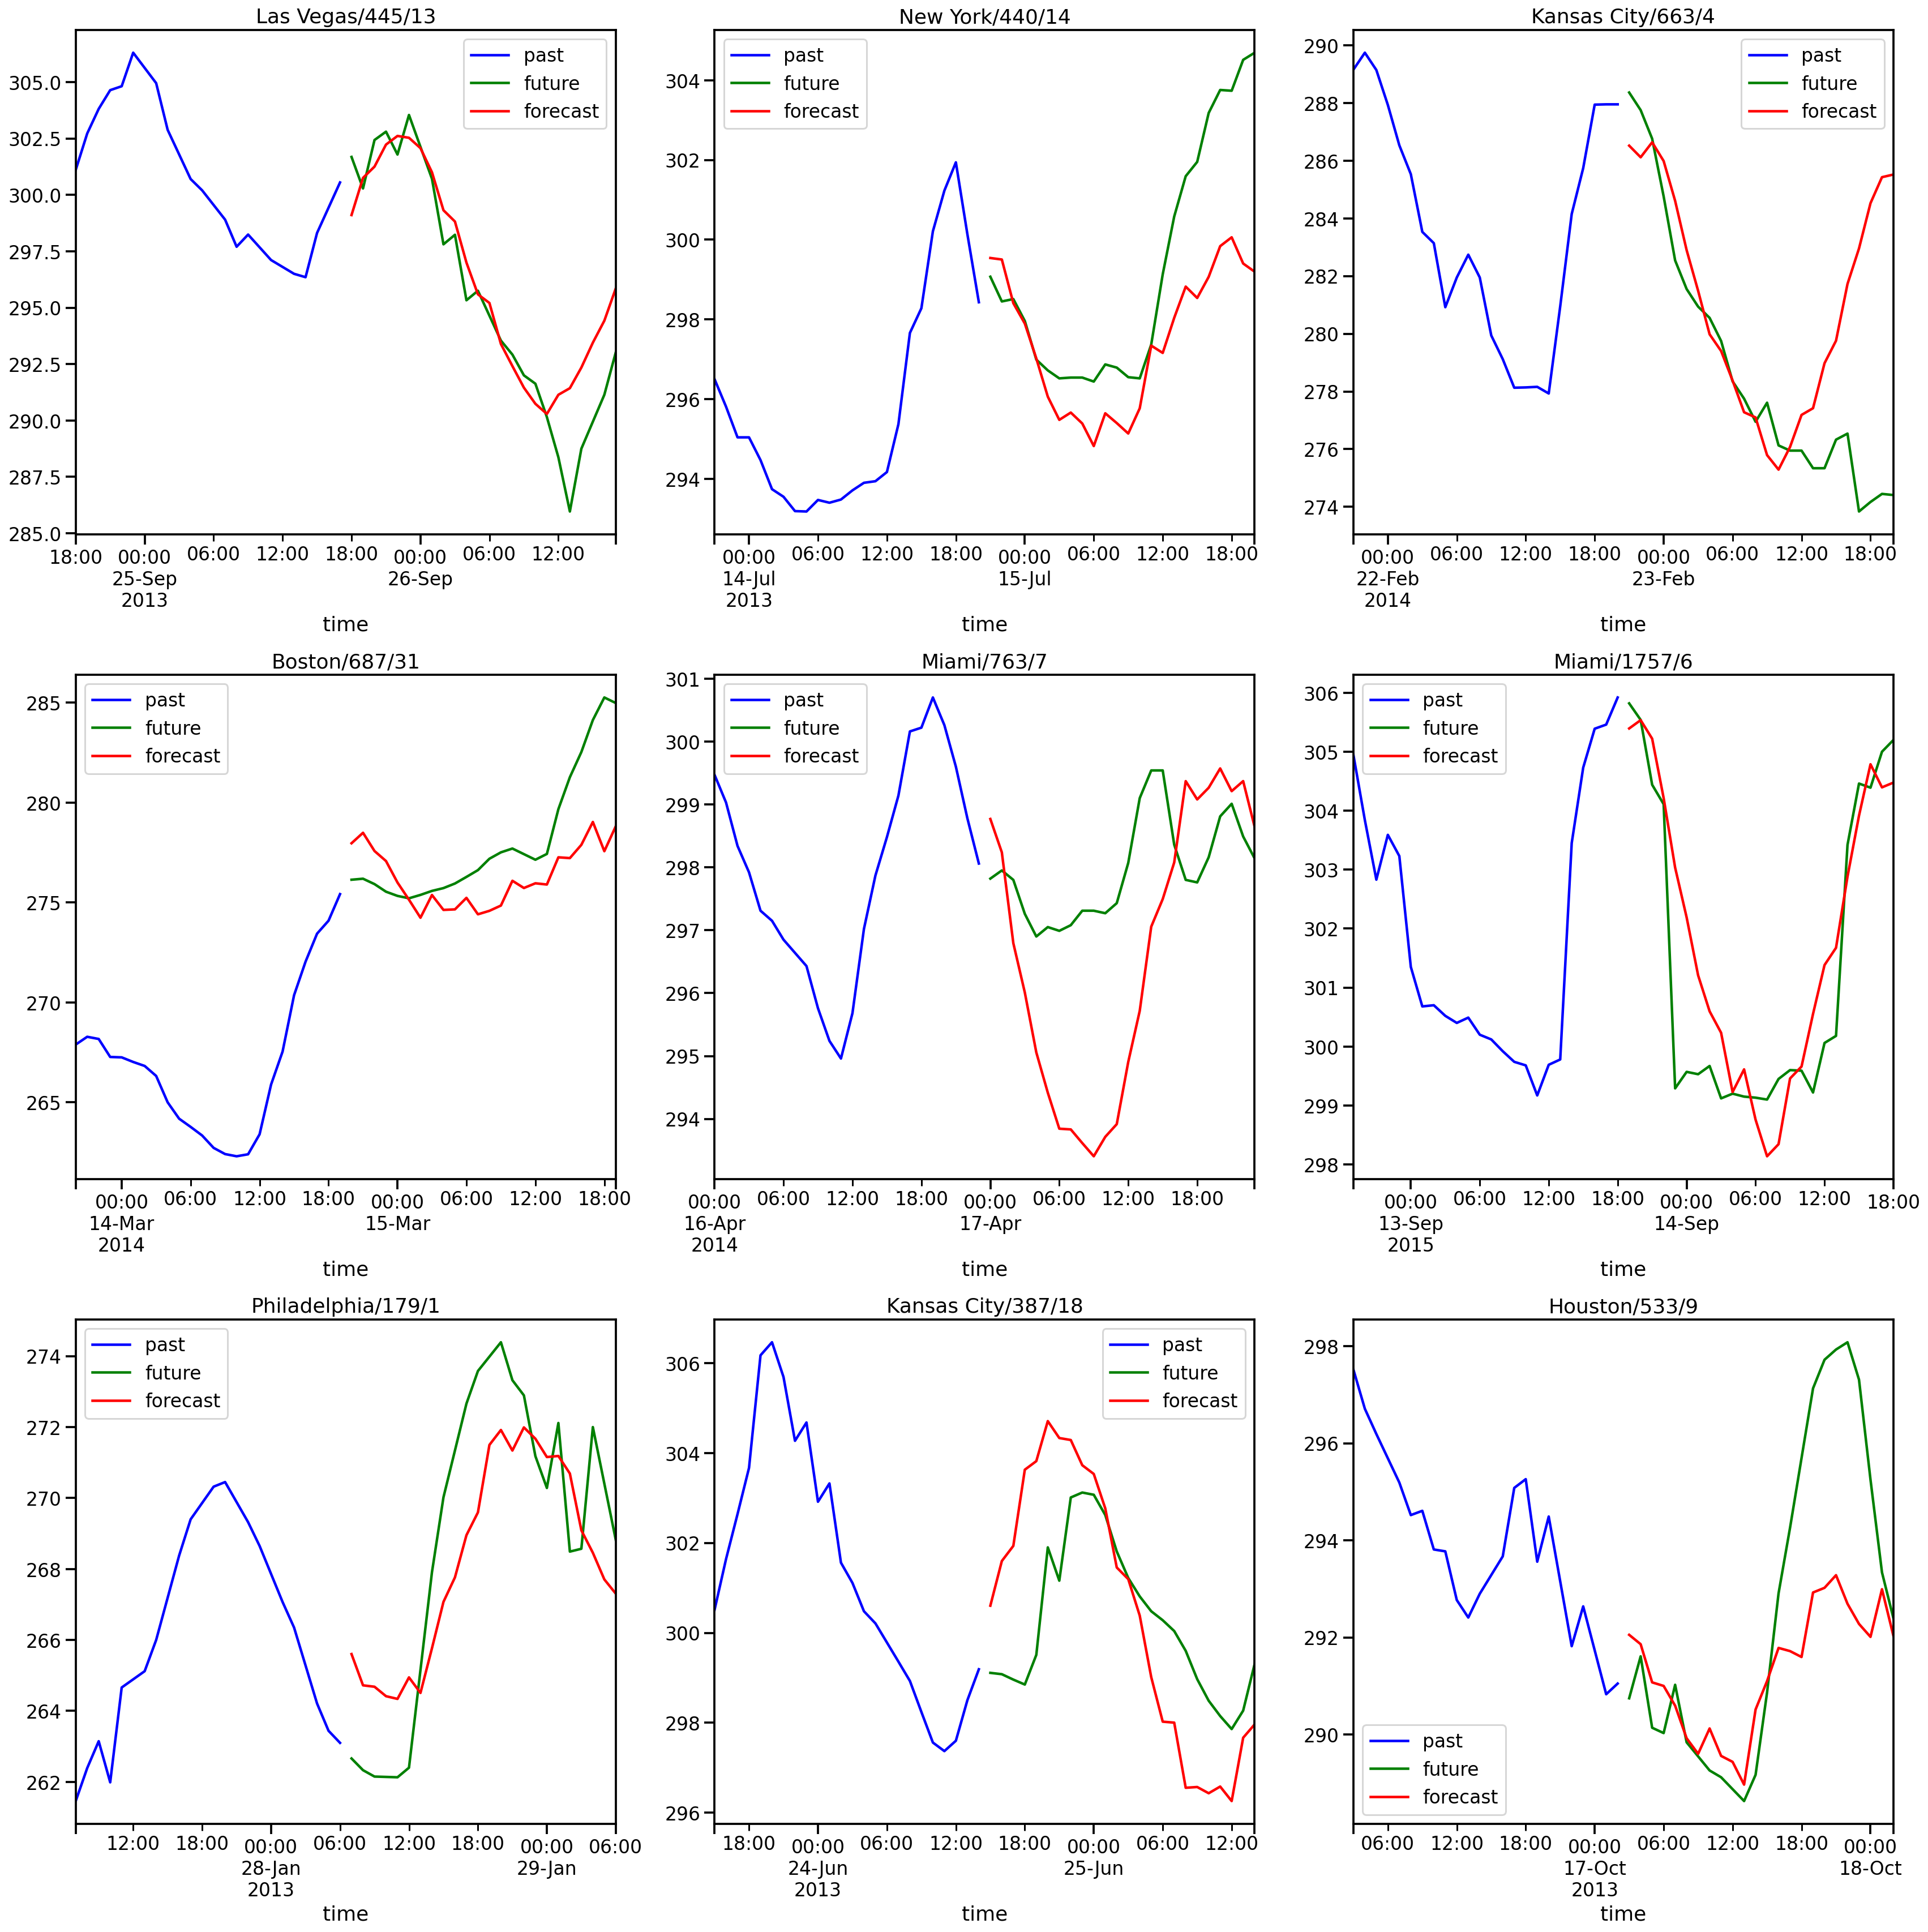

In [30]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() inst

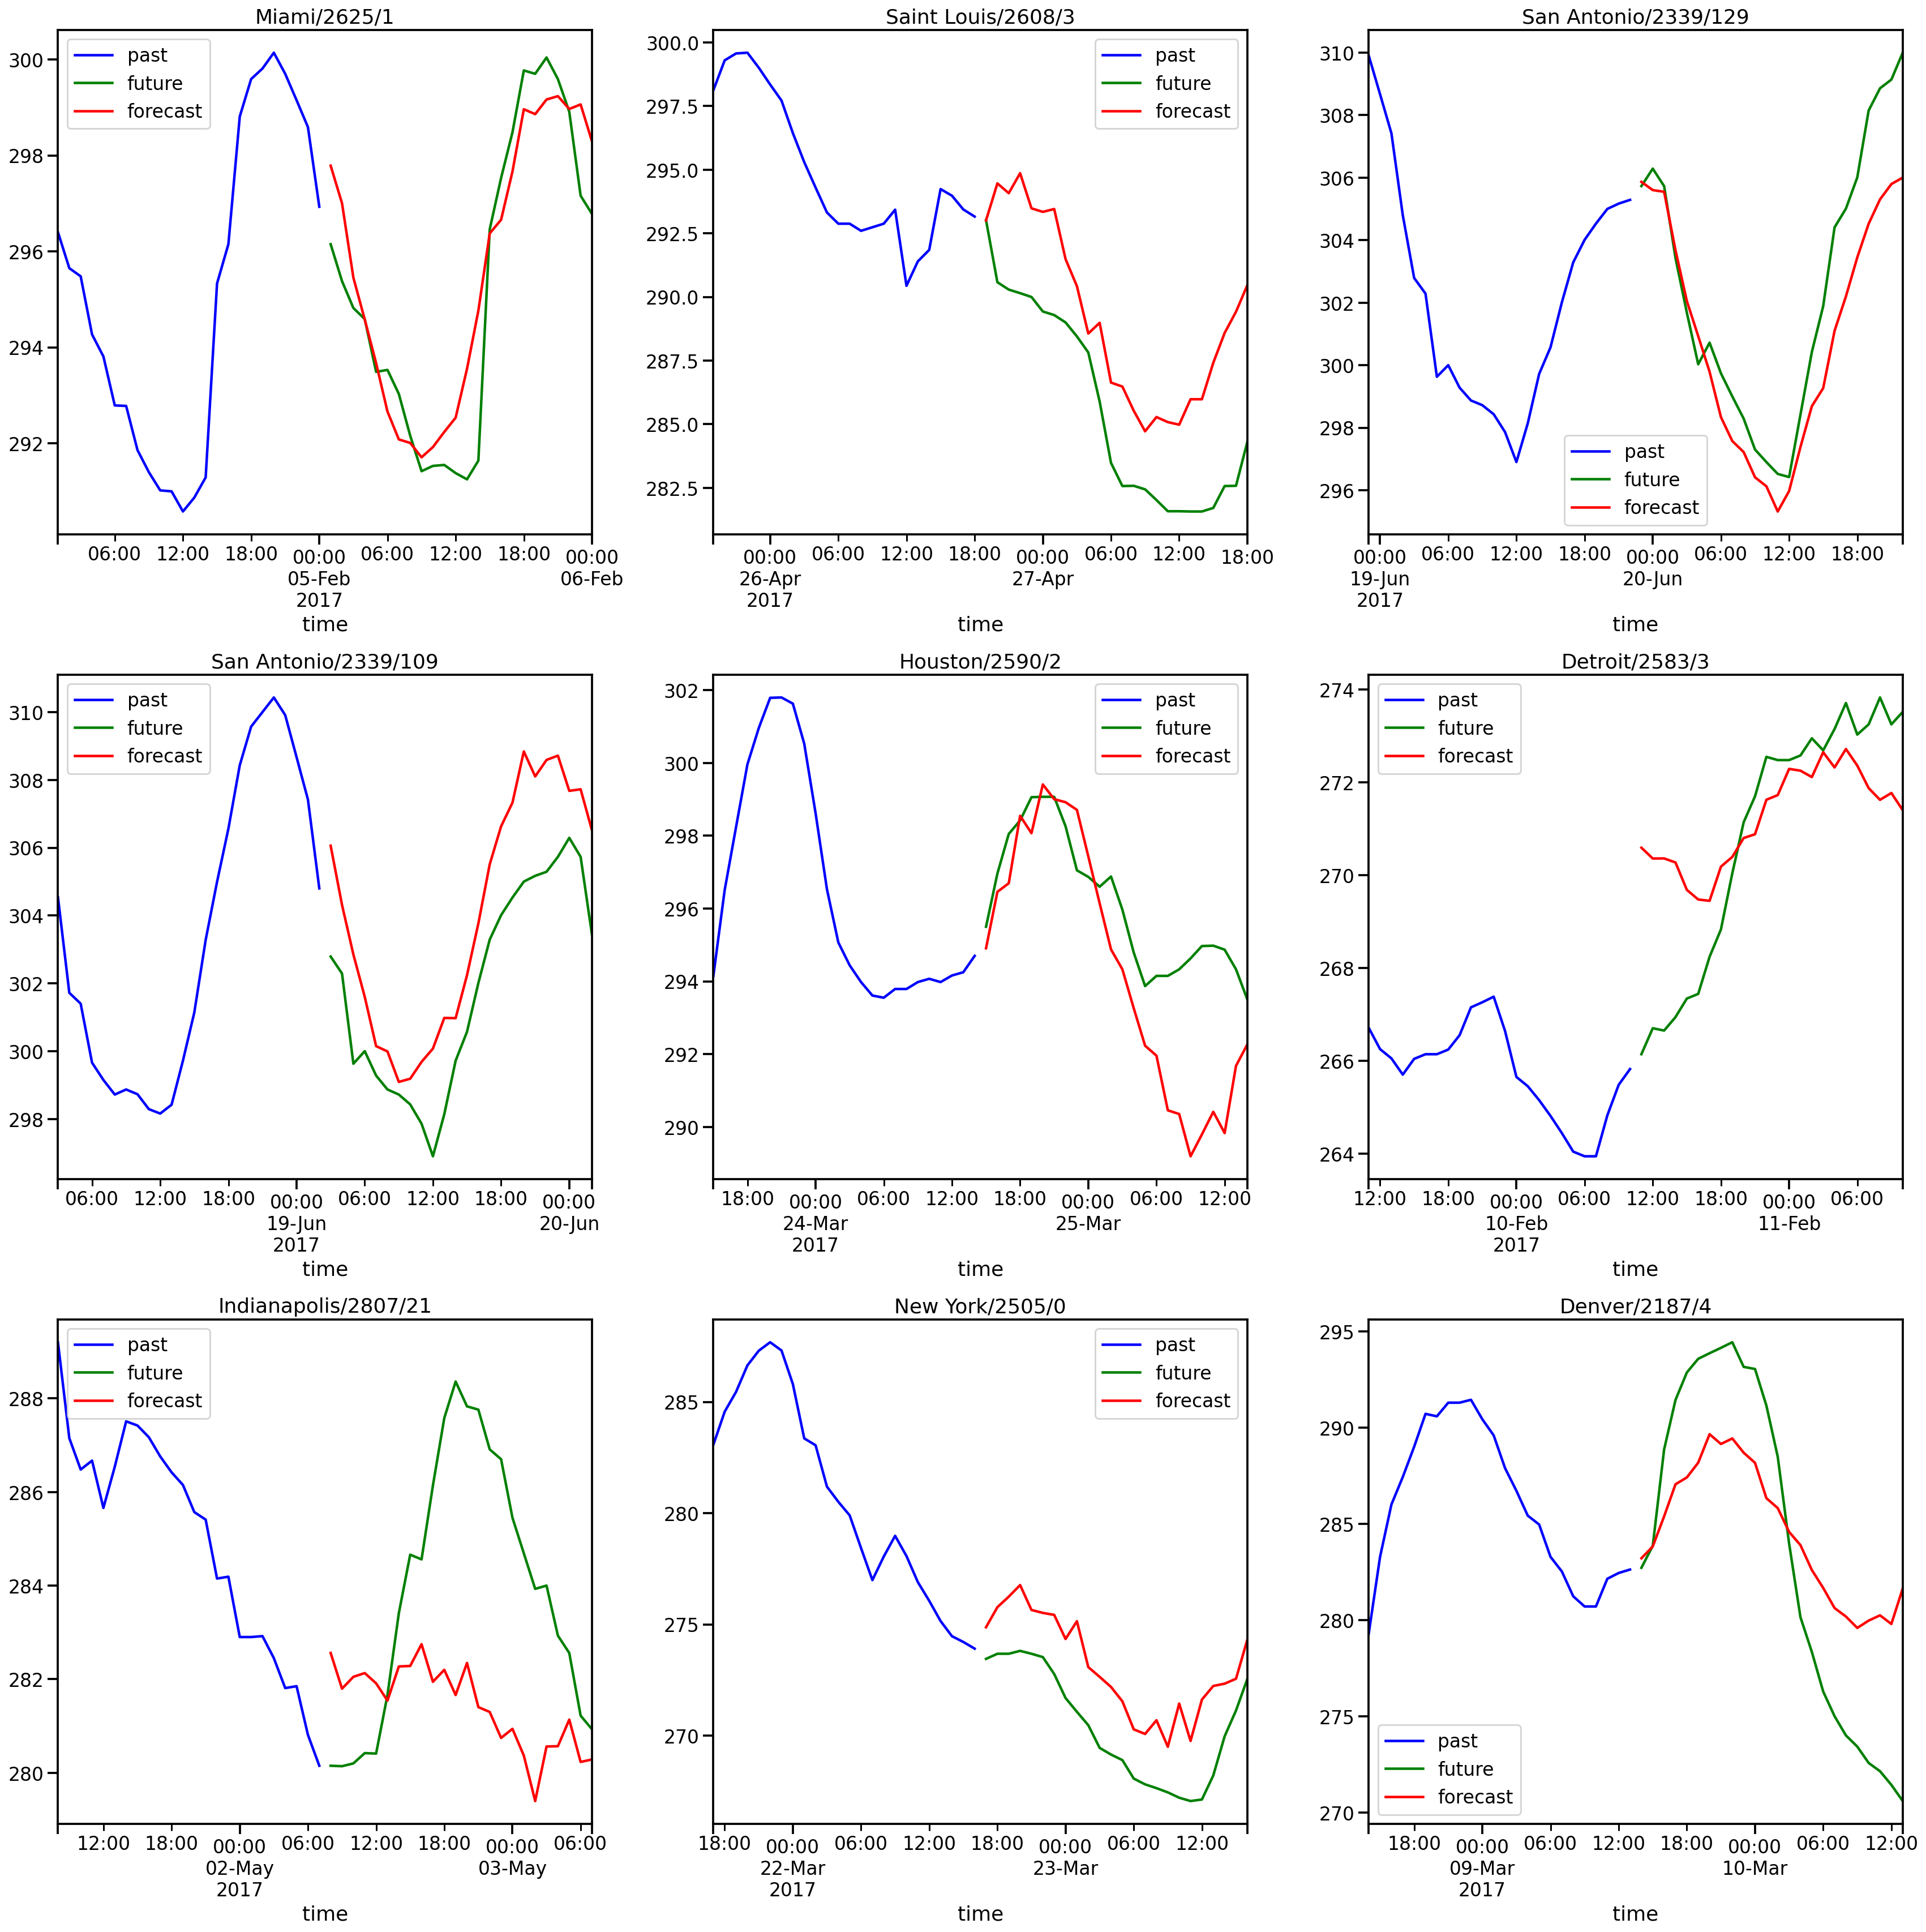

In [31]:
from utils import nd_target_like_panel, plot_random_forecasts

test_y_hat = nd_target_like_panel(test_y, model.predict(test_X_nd))

plot_random_forecasts(
    test_X['temperature'],
    test_y['temperature'],
    test_y_hat.rename(columns={'temperature': 'forecast'})
)

## Check model on original datasets

In [34]:
og_train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
og_train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

og_validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
og_validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

og_test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
og_test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [35]:
og_scaled_X = {
    'og_train': scaler.transform(og_train_X),
    'og_validate': scaler.transform(og_validate_X),
    'og_test': scaler.transform(og_test_X)
}

In [36]:
og_train_X_nd, og_train_y_nd = frame_to_ndarray(og_scaled_X['og_train'], og_train_y)
og_validate_X_nd, og_validate_y_nd = frame_to_ndarray(og_scaled_X['og_validate'], og_validate_y)
og_test_X_nd, og_test_y_nd = frame_to_ndarray(og_scaled_X['og_test'], og_test_y)

In [37]:
og_nd_array_by_segment = {
    'train': (og_train_X_nd, og_train_y_nd),
    'validate': (og_validate_X_nd, og_validate_y_nd),
    'test': (og_test_X_nd, og_test_y_nd)
}

og_metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in og_nd_array_by_segment.items()
}

og_rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in og_metrics_by_segment.items()
])

og_rnn_metrics = pd.DataFrame([og_rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(og_nd_array_by_segment.keys(), axis=1, level=0)\
    .round(5)

og_rnn_metrics

train                             validate                             \
          MSE      MAE       R2       ME       MSE      MAE       R2       ME   
rnn  10.11204  2.32969  0.92832 -0.04208  19.68961  3.33863  0.77983  0.21371   

         test                             
          MSE      MAE       R2       ME  
rnn  13.19221  2.75808  0.82393 -0.54428

In [40]:
import utils

og_segment_names = ['train', 'validate', 'test']
og_segment_data = [(og_train_X, og_train_y), (og_validate_X, og_validate_y), (og_test_X, og_test_y)]
og_out_list = []
for segment, data in zip(og_segment_names, og_segment_data):
    tmp_segment = Segment(segment)
    for frame_name, frame_data in zip(['x', 'y'], data):
        tmp_segment.frames[frame_name] = frame_data
    og_out_list.append(tmp_segment)

og_panel_dataset = SegmentDataset()
for name, data in zip(og_segment_names, og_out_list):
    og_panel_dataset[name] = data
og_baseline_metrics = utils.baseline_metrics(og_panel_dataset)

In [41]:
pd.concat([
    og_baseline_metrics,
    og_rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(3)

test          train        validate      
               MSE     R2     MSE     R2      MSE    R2
mean        28.520  0.610  26.770  0.800    37.23  0.58
constant    20.200  0.720  21.820  0.840    40.25  0.54
regression  33.640  0.540  30.530  0.780    29.94  0.66
rnn         13.192  0.824  10.112  0.928    19.69  0.78

## Submission

In [32]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

score_y_hat = model.predict(score_X_nd)
score_y_hat = score_y_hat.reshape(-1,1)

score_y_hat = pd.DataFrame(score_y_hat, columns=['temperature'])

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [33]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')